## SETUP

##### Libraries & API Setup

In [1]:
# Common libraries
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import json 
import pandas as pd
import datetime
from utils import returns_df, plot_prices, plot_returns, plot_tvl

In [2]:
# API setup
from messari.messari import Messari                   # Messari
#m = Messari('cb0d3a33-c4c5-4b50-9fff-5dce65d44b97')   # Messari
m = Messari('f8783744-faf2-475e-8675-b3769cd55c81')   # Messari
from pycoingecko import CoinGeckoAPI                  # Coingecko
cg = CoinGeckoAPI()                                   # Coingecko
API_KEY = '27mKdxqslM3aORzuco6LoqzKjFc'               # Glassnode

##### Import Data

In [3]:
start = '2022-01-01'
end = '2022-03-31'
sector = ('UNI', 'CRV', 'LRC', 'SUSHI')

In [4]:
cdata = pd.DataFrame(cg.get_coins_markets('usd'))

In [5]:
mdata = m.get_all_assets(asset_fields=['metrics'], to_dataframe=True)
prices = m.get_metric_timeseries(list(sector), 'price', start, end)
asset_returns = returns_df(prices)

In [6]:
ldata = pd.DataFrame(requests.get('https://api.llama.fi/protocols').json())

##### Coarse Merge

In [7]:
cdata['symbol'].str.lower()
master = cdata.merge(ldata, how = 'left', left_on = 'symbol', right_on = 'symbol')

In [8]:
master = master.merge(mdata, how = 'left', left_on = 'id_x', right_on = 'slug')

## METRICS

### Price Action 

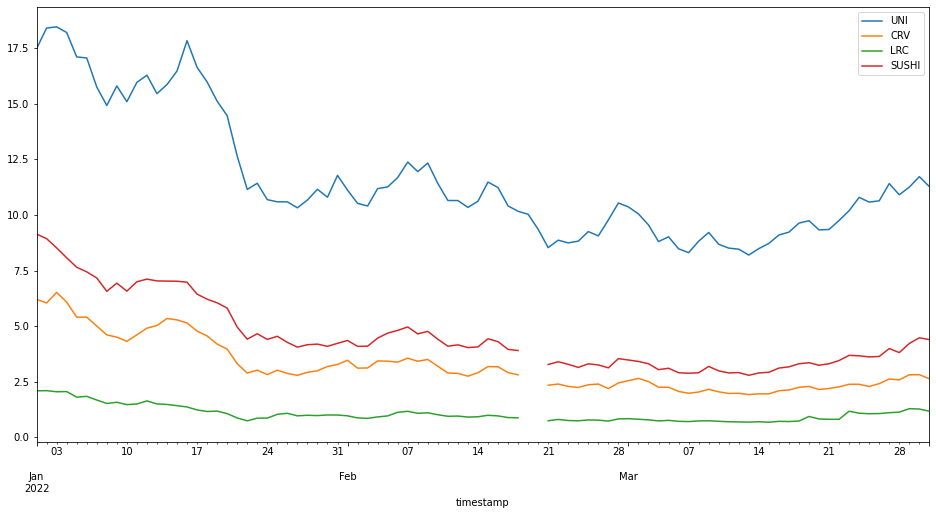

In [9]:
plot_prices(prices, sector) #Fix gap in data

### Returns

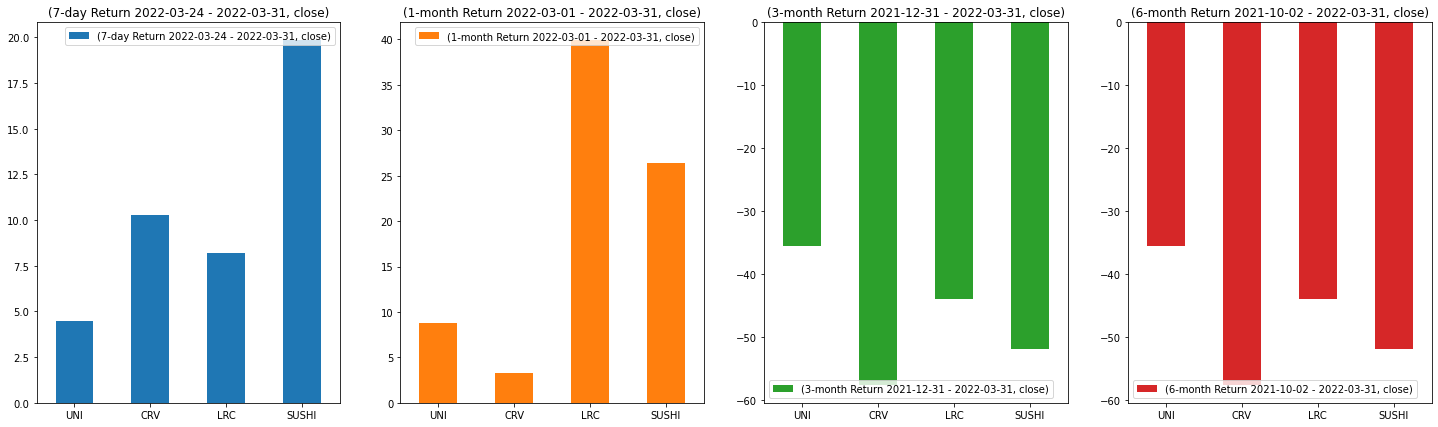

In [10]:
plot_returns(asset_returns, sector)

### TVL

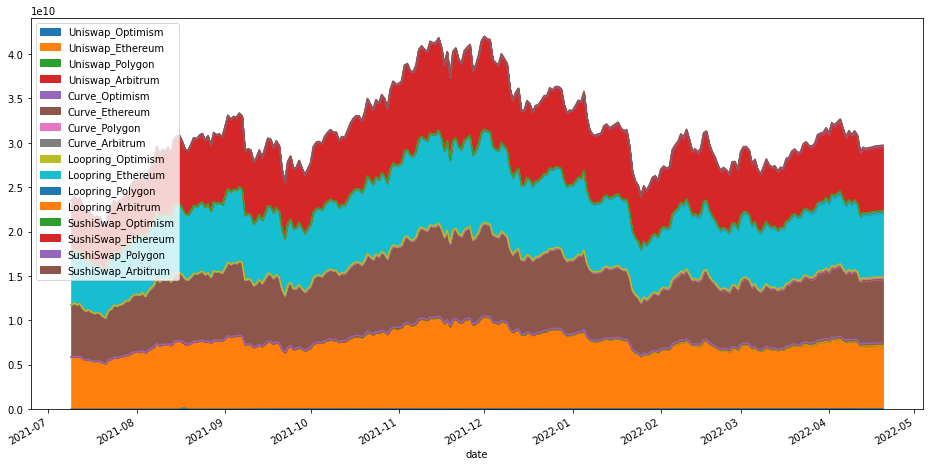

In [11]:
plot_tvl(ldata, sector)

## On-chain Metrics

### Active Addresses

<AxesSubplot:xlabel='timestamp'>

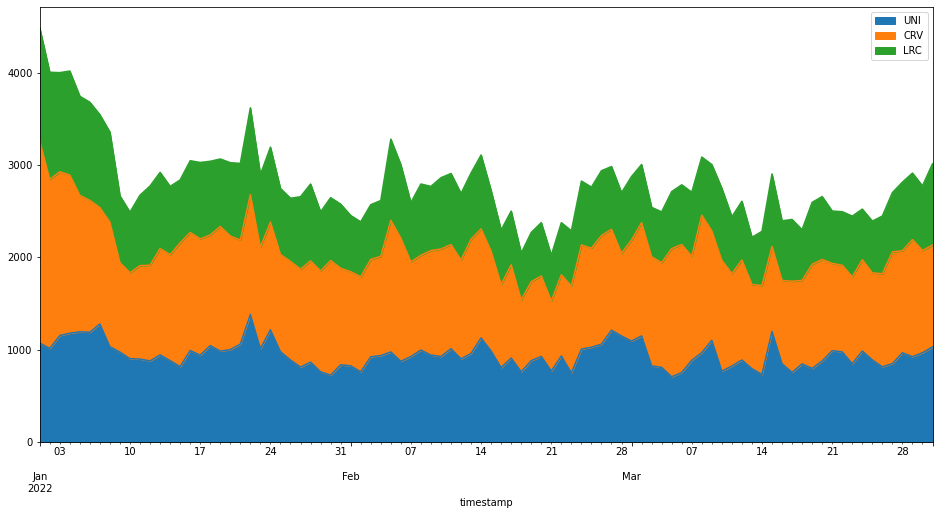

In [12]:
d = m.get_metric_timeseries(list(sector), 'act.addr.cnt', start, end)
d.plot.area(figsize = (16, 8))

### Transaction Count

<AxesSubplot:xlabel='timestamp'>

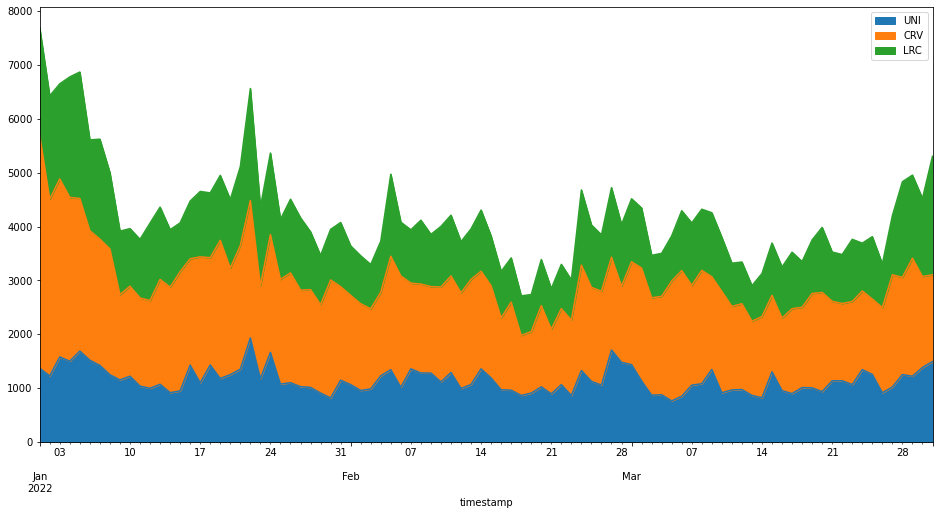

In [13]:
d = m.get_metric_timeseries(list(sector), 'txn.cnt', start, end)
d.plot.area(figsize = (16, 8))

### Transaction Volume

<AxesSubplot:xlabel='timestamp'>

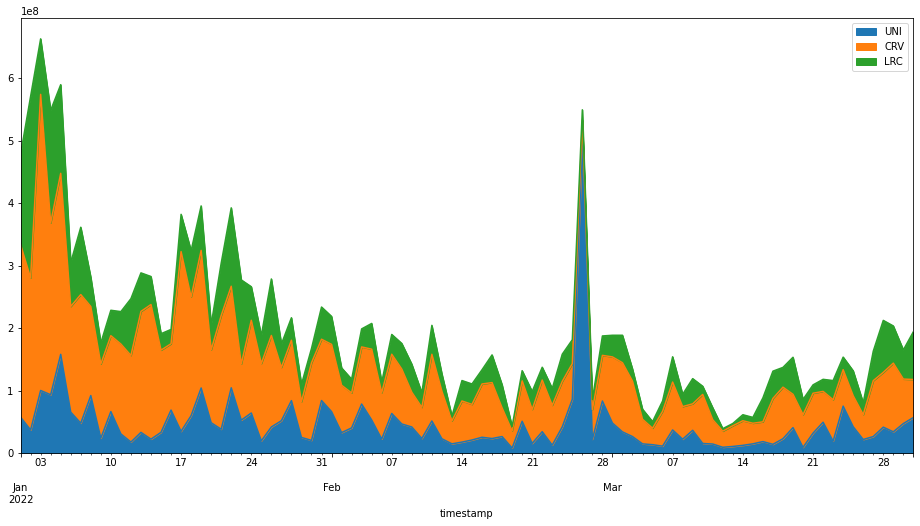

In [14]:
d = m.get_metric_timeseries(list(sector), 'txn.vol', start, end)
d.plot.area(figsize = (16, 8))